# cygnus-cache-individual

Analyze cache behavior of Cygnus / Best Fixed Offset (BFO) on single traces.


In [1]:
from importlib import reload

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import plots, tables
#%matplotlib widget

In [2]:
# Knobs
paths = {
    'degree1_fixed_offset': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_fixed_offset.csv', # Different fixed offsets (-64 to +63)
    'degree1_featureless_nozeroaction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_featureless_nozeroaction.csv',
    'degree1_fixed_offset_strictpageboundary_8': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_fixed_offset_strictpageboundary_8.csv',
}
dpi = 192

# Plots (suites)
Fix prefetch degree to 1 for everything.

In [3]:
from importlib import reload
from utils import utils
reload(tables)
reload(utils)
dfs = {
    'degree1_fixed_offset': tables.load_stats_csv_next_line(paths['degree1_fixed_offset']),
    'degree1_featureless_nozeroaction': tables.load_stats_csv(paths['degree1_featureless_nozeroaction'], ['cygnus', 'bo'], prefetchers_level='l2'),
    'degree1_fixed_offset_strictpageboundary_8': tables.load_stats_csv_next_line(paths['degree1_fixed_offset_strictpageboundary_8']),
}

## Helper functions

In [4]:
def get_value(df, trace, key):
    col = df[df.run_name == trace][key]
    return col.iloc[0].item()

libq_prefetchers = {
    'Cygnus': dfs['degree1_featureless_nozeroaction']['cygnus'],
    'BO': dfs['degree1_featureless_nozeroaction']['bo'],
    #'+1': dfs['degree1_fixed_offset']['1'],
    #'+2': dfs['degree1_fixed_offset']['2'],
    '+4': dfs['degree1_fixed_offset']['4'],
    #'+9': dfs['degree1_fixed_offset']['9'],
    #'+10': dfs['degree1_fixed_offset']['10'],
    '+8': dfs['degree1_fixed_offset']['8'],
}

mcf_prefetchers = {
    'Cygnus': dfs['degree1_featureless_nozeroaction']['cygnus'],
    'BO': dfs['degree1_featureless_nozeroaction']['bo'],
    '+1 (BFO)': dfs['degree1_fixed_offset']['best'],
}

delta_prefetchers = {
    'Cygnus': dfs['degree1_featureless_nozeroaction']['cygnus'],
    'BO': dfs['degree1_featureless_nozeroaction']['bo'],
    'BFO': dfs['degree1_fixed_offset']['best'],
}

merced_prefetchers = {
    'Cygnus': dfs['degree1_featureless_nozeroaction']['cygnus'],
    'BO': dfs['degree1_featureless_nozeroaction']['bo'],
    'BFO': dfs['degree1_fixed_offset']['best'],
}

## Access distributions

In [5]:
def plot_stacked_accesses(prefetchers, trace, figsize=(8,5)):
    hits = {}
    misses = {}
    misses_mshr_hit = {}
    pf_hits = {}
    pf_misses = {}
    X = [0, 1, 2]

    first_df = list(prefetchers.values())[0]
    for level in ['L1D', 'L2C', 'LLC']:
       hits[f'no {level}'] = get_value(first_df, trace, f'{level}_hits_baseline')
       misses[f'no {level}'] = get_value(first_df, trace, f'{level}_misses_baseline')
       misses_mshr_hit[f'no {level}'] = 0
       pf_hits[f'no {level}'] = 0
       pf_misses[f'no {level}'] = 0

    for i, (k, v) in enumerate(prefetchers.items()):
       for level in ['L1D', 'L2C', 'LLC']:
           hits[f'{k} {level}'] = get_value(v, trace, f'{level}_hits')
           misses[f'{k} {level}'] = get_value(v, trace, f'{level}_misses')
           misses_mshr_hit[f'{k} {level}'] = get_value(v, trace, f'{level}_misses_mshr_hit')
           pf_hits[f'{k} {level}'] = get_value(v, trace, f'{level}_pf_hits')
           pf_misses[f'{k} {level}'] = get_value(v, trace, f'{level}_pf_misses')
       X.extend((i + 1) * 4 + np.arange(3))

    labels = np.array(list(hits.keys()))
    hits_arr = np.array(list(hits.values()))
    misses_mshr_miss_arr = np.array(list(misses.values())) - np.array(list(misses_mshr_hit.values()))
    misses_mshr_hit_arr = np.array(list(misses_mshr_hit.values()))
    pf_hits_arr = np.array(list(pf_hits.values()))
    pf_misses_arr = np.array(list(pf_misses.values()))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.bar(X, hits_arr, label='demand hits', color='C2')
    ax.bar(X, misses_mshr_miss_arr, label='demand misses (MSHR miss)', color='C0',
           bottom=hits_arr)
    ax.bar(X, misses_mshr_hit_arr, label='demand misses (MSHR hit)', color='lightsteelblue',
           bottom=hits_arr + misses_mshr_miss_arr)
    ax.bar(X, pf_hits_arr, label='prefetch hits', color='gold',
           bottom=hits_arr + misses_mshr_miss_arr + misses_mshr_hit_arr)
    ax.bar(X, pf_misses_arr, label='prefetch misses', color='C1',
           bottom=hits_arr + misses_mshr_miss_arr + misses_mshr_hit_arr + pf_hits_arr)

    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Accesses')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    fig.suptitle(f'{trace} access distribution')
    fig.legend(fontsize=8)

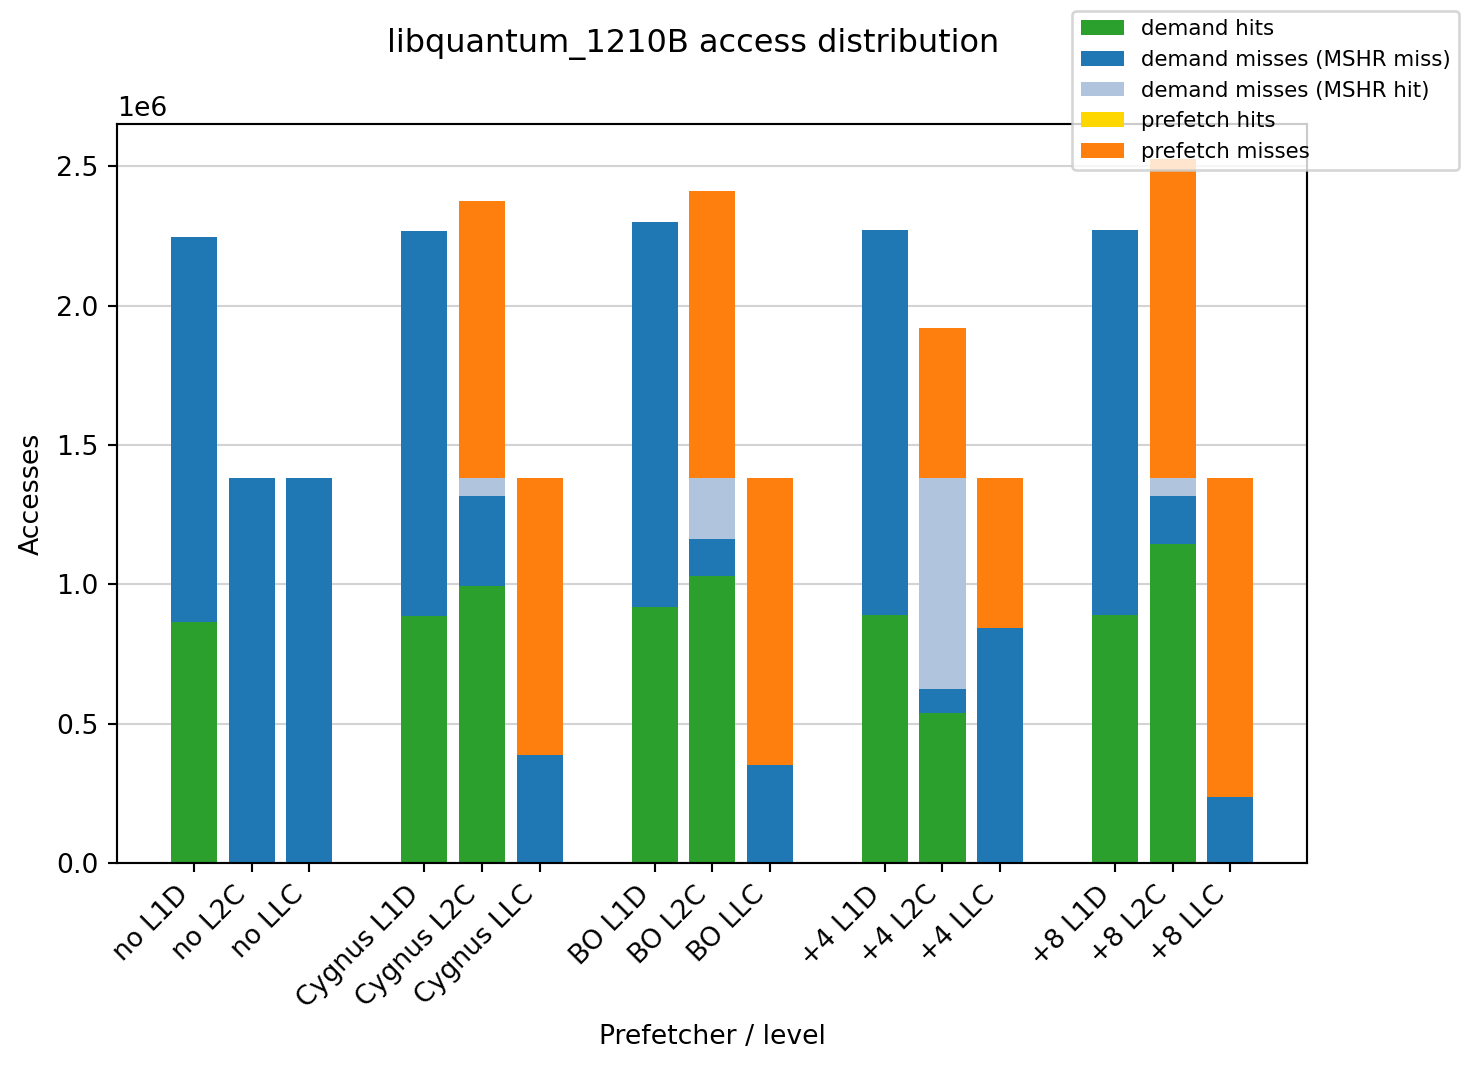

In [6]:
plot_stacked_accesses(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))
# plot_stacked_accesses(mcf_prefetchers, 'mcf_46B')
# plot_stacked_accesses(delta_prefetchers, 'delta_507252')
# plot_stacked_accesses(merced_prefetchers, 'merced_467642')

## Access cycles

**TODO**: Break (timely) prefetch cycles down by whether or not they are useful (i.e. yield a hit).

In [7]:
def plot_access_cycles(prefetchers, trace, figsize=(8,5)):
   # hit_cycles = {}
    miss_cycles = {}
    miss_mshr_hit_cycles = {}
    miss_exposed_cycles = {}
    miss_mshr_hit_exposed_cycles = {}
    prefetch_cycles = {}
    prefetch_useless_cycles = {}
    X = [0, 1, 2]
    
    first_df = list(prefetchers.values())[0]
    for level in ['L1D', 'L2C', 'LLC']:
        miss_cycles[f'no {level}'] = get_value(first_df, trace, f'{level}_miss_cycles')
        miss_mshr_hit_cycles[f'no {level}'] = 0
        miss_exposed_cycles[f'no {level}'] = miss_cycles[f'no {level}']
        miss_mshr_hit_exposed_cycles[f'no {level}'] = 0
        prefetch_cycles[f'no {level}'] = 0


    for i, (k, v) in enumerate(prefetchers.items()):
        for level in ['L1D', 'L2C', 'LLC']:
            miss_cycles[f'{k} {level}'] = get_value(v, trace, f'{level}_miss_cycles')
            miss_mshr_hit_cycles[f'{k} {level}'] = get_value(v, trace, f'{level}_miss_mshr_hit_cycles')
            miss_exposed_cycles[f'{k} {level}'] = get_value(v, trace, f'{level}_exposed_miss_cycles')
            miss_mshr_hit_exposed_cycles[f'{k} {level}'] = get_value(v, trace, f'{level}_exposed_miss_mshr_hit_cycles')
            prefetch_cycles[f'{k} {level}'] = get_value(v, trace, f'{level}_pf_miss_cycles')

        X.extend((i + 1) * 4 + np.arange(3))

    labels = np.array(list(miss_cycles.keys()))

    miss_mshr_hit_cycles_exposed_arr = np.array(list(miss_mshr_hit_exposed_cycles.values()))
    miss_cycles_exposed_arr = np.array(list(miss_exposed_cycles.values())) - miss_mshr_hit_cycles_exposed_arr
    miss_cycles_hidden_arr = np.array(list(miss_cycles.values())) - np.array(list(miss_exposed_cycles.values()))
    prefetch_cycles_arr = np.array(list(prefetch_cycles.values()))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.bar(X, miss_cycles_exposed_arr, label='exposed miss cycles (MSHR miss)', color='C3')
    ax.bar(X, miss_mshr_hit_cycles_exposed_arr, label='exposed miss cycles (MSHR hit)', color='lightcoral',
           bottom=miss_cycles_exposed_arr)
    ax.bar(X, miss_cycles_hidden_arr, label='hidden miss cycles (MSHR hit)', color='C0',
           bottom=miss_cycles_exposed_arr + miss_mshr_hit_cycles_exposed_arr)
    ax.bar(X, prefetch_cycles_arr, label='prefetch cycles', color='C1',
           bottom=miss_cycles_exposed_arr + miss_mshr_hit_cycles_exposed_arr + miss_cycles_hidden_arr)

    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Cycles')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    fig.suptitle(f'{trace} cycles distribution')
    fig.legend(fontsize=8)

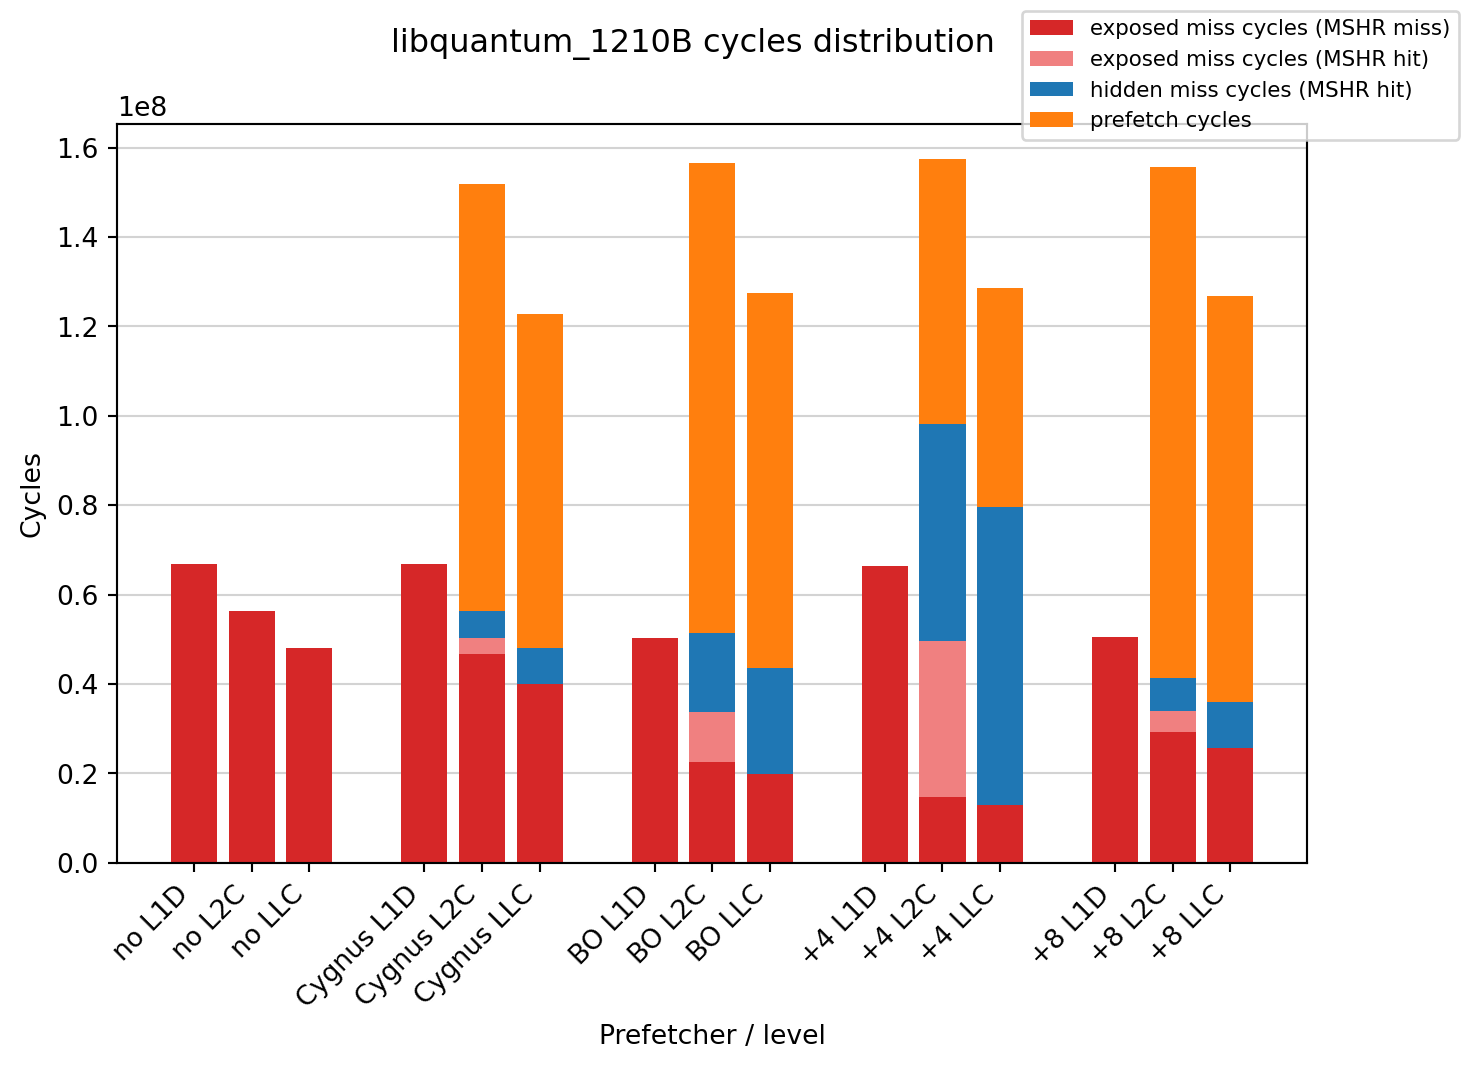

In [8]:
plot_access_cycles(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))
#plot_access_cycles(mcf_prefetchers, 'mcf_46B', figsize=(8, 5))
#plot_access_cycles(delta_prefetchers, 'delta_507252', figsize=(8, 5))
#plot_access_cycles(merced_prefetchers, 'merced_467642', figsize=(8, 5))

## Average miss cycles

In [9]:
def plot_avg_miss_cycles(prefetchers, trace, figsize=(8,5), denominator='miss'):
    avg_miss_cycles = {}
    avg_miss_exposed_cycles = {}
    X = [0, 1, 2]
    
    first_df = list(prefetchers.values())[0]
    for cache in ['L1D', 'L2C', 'LLC']:
        num_miss_cycles = get_value(first_df, trace, f'{cache}_miss_cycles_baseline')
        num_misses = get_value(first_df, trace, f'{cache}_misses_baseline') 
        num_accesses = get_value(first_df, trace, f'{cache}_accesses_baseline')

        if denominator == 'miss':
            avg_miss_cycles[f'no {cache}'] = num_miss_cycles / num_misses
            avg_miss_exposed_cycles[f'no {cache}'] = num_miss_cycles / num_misses
        elif denominator == 'access':
            avg_miss_cycles[f'no {cache}'] = num_miss_cycles / num_accesses
            avg_miss_exposed_cycles[f'no {cache}'] = num_miss_cycles / num_accesses

    for i, (k, v) in enumerate(prefetchers.items()):
        for cache in ['L1D', 'L2C', 'LLC']:
            num_miss_cycles = get_value(v, trace, f'{cache}_miss_cycles')
            num_miss_exposed_cycles = get_value(v, trace, f'{cache}_exposed_miss_cycles')
            num_misses = get_value(v, trace, f'{cache}_misses')
            num_accesses = get_value(v, trace, f'{cache}_accesses')

            if denominator == 'miss':
                avg_miss_cycles[f'{k} {cache}'] = num_miss_cycles / num_misses
                avg_miss_exposed_cycles[f'{k} {cache}'] = num_miss_exposed_cycles / num_misses
            elif denominator == 'access':
                avg_miss_cycles[f'{k} {cache}'] = num_miss_cycles / num_accesses
                avg_miss_exposed_cycles[f'{k} {cache}'] = num_miss_exposed_cycles / num_accesses
            
        X.extend((i + 1) * 4 + np.arange(3))

    labels = np.array(list(avg_miss_cycles.keys()))
    avg_miss_cycles_arr = np.array(list(avg_miss_cycles.values()))
    avg_miss_exposed_cycles_arr = np.array(list(avg_miss_exposed_cycles.values()))

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(X, avg_miss_exposed_cycles_arr, label=f'avg. miss cycles per {denominator} (exposed)', bottom=0, color='C3')
    ax.bar(X, avg_miss_cycles_arr - avg_miss_exposed_cycles_arr, label=f'avg. miss cycles per {denominator} (hidden by late prefetch)', bottom=avg_miss_exposed_cycles_arr)


    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Cycles')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    fig.suptitle(f'{trace} miss cycles per {denominator}')
    fig.legend(fontsize=8)

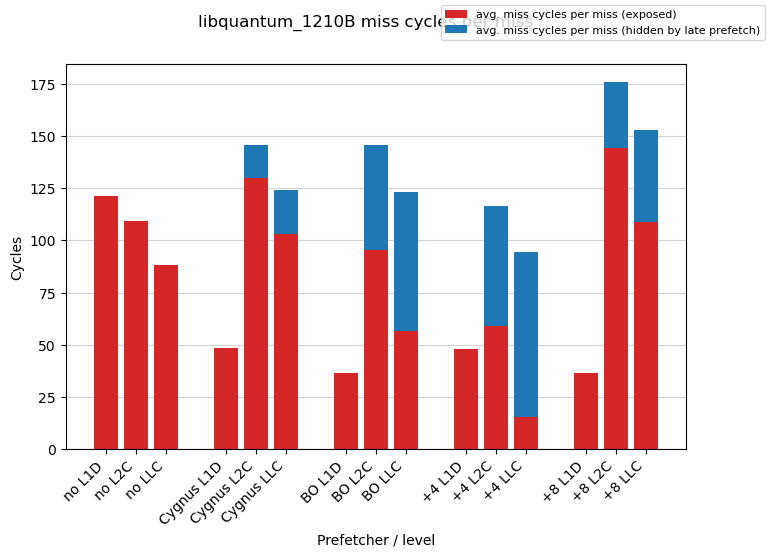

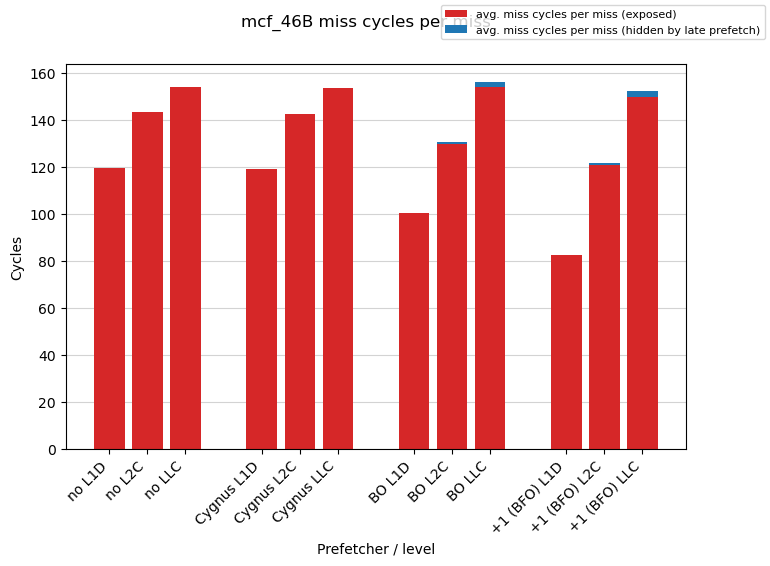

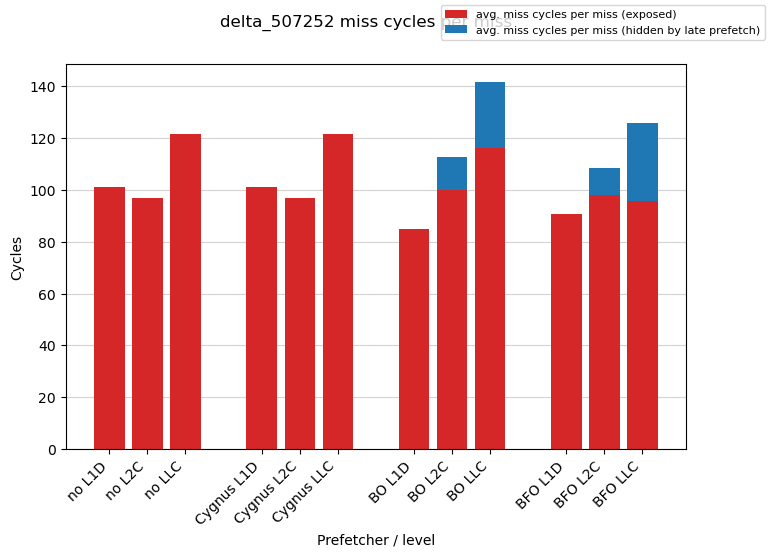

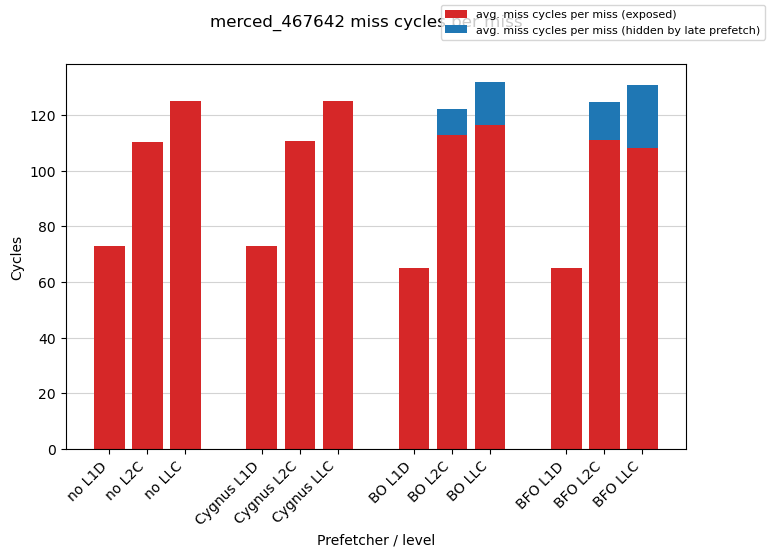

In [10]:
plot_avg_miss_cycles(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5), denominator='miss')
plot_avg_miss_cycles(mcf_prefetchers, 'mcf_46B', figsize=(8, 5), denominator='miss')
plot_avg_miss_cycles(delta_prefetchers, 'delta_507252', figsize=(8, 5), denominator='miss')
plot_avg_miss_cycles(merced_prefetchers, 'merced_467642', figsize=(8, 5), denominator='miss')

## Useful counts

In [11]:
def plot_useful_counts(prefetchers, trace, figsize=(8,5)):
    useful_timely = {}
    useful_late = {}
    useless_unused = {}
    useless_hit = {}
    X = []
    
    first_df = list(prefetchers.values())[0]

    for i, (k, v) in enumerate(prefetchers.items()):
        useful_timely[f'{k} L2'] = get_value(v, trace, 'L2C_pf_useful_timely')
        useful_late[f'{k} L2'] = get_value(v, trace, 'L2C_pf_useful_late')
        useless_unused[f'{k} L2'] = get_value(v, trace, 'L2C_pf_useless_unused')
        useless_hit[f'{k} L2'] = get_value(v, trace, 'L2C_pf_useless_hit')
        X.append(i)

    labels = np.array(list(useful_timely.keys()))
    useful_timely_arr = np.array(list(useful_timely.values()))
    useful_late_arr = np.array(list(useful_late.values()))
    useless_unused_arr = np.array(list(useless_unused.values()))
    useless_hit_arr = np.array(list(useless_hit.values()))

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(X, useful_timely_arr, label='useful timely', color='C0')
    ax.bar(X, useful_late_arr, label='useful late', bottom=useful_timely_arr, color='C1')
    ax.bar(X, useless_unused_arr, label='useless unused', bottom=useful_timely_arr + useful_late_arr, color='C2')
    ax.bar(X, useless_hit_arr, label='useless hit', bottom=useful_timely_arr + useful_late_arr + useless_unused_arr, color='C3')


    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Count')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    fig.suptitle(f'{trace} useful prefetches')
    fig.legend()

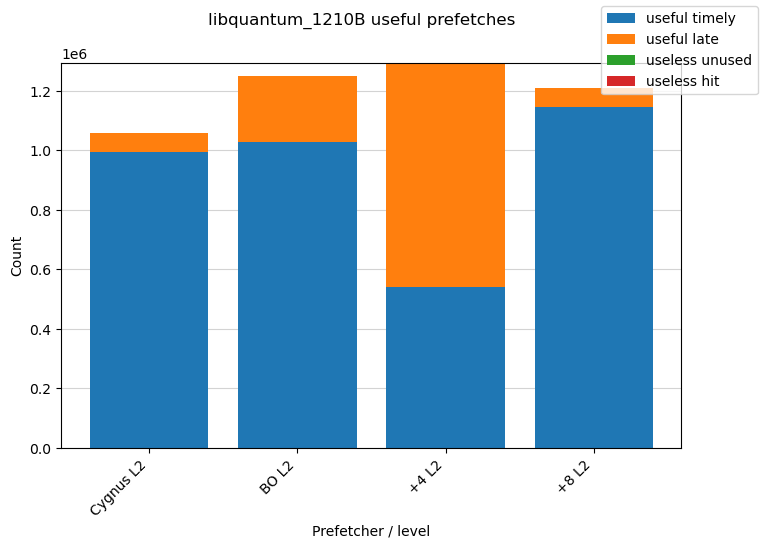

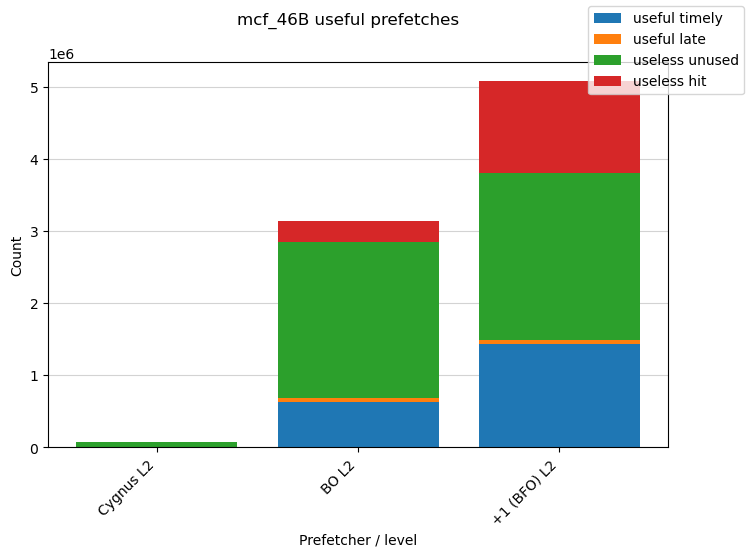

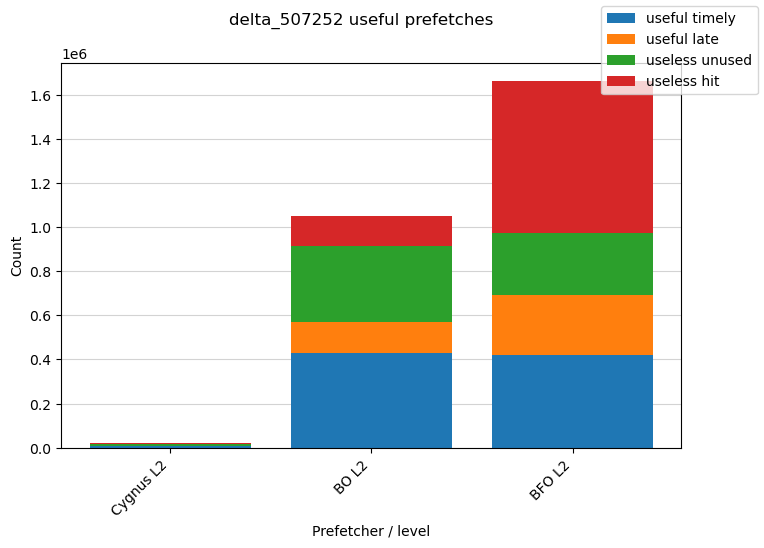

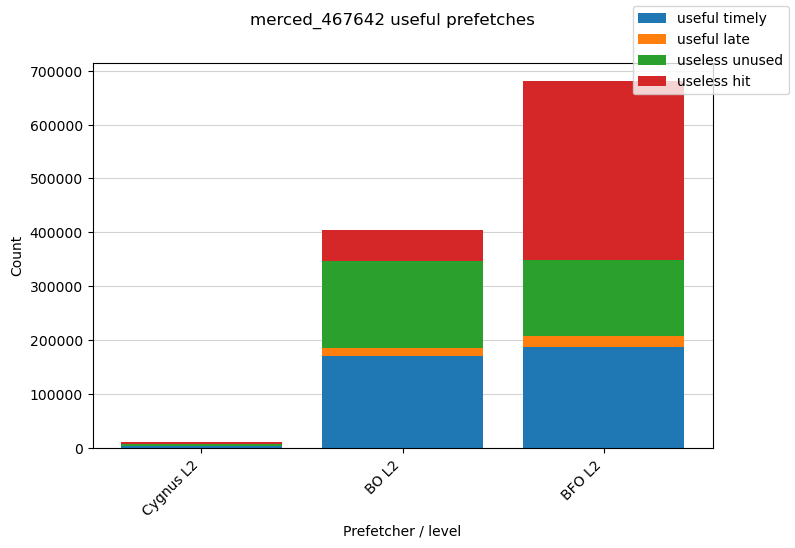

In [12]:
plot_useful_counts(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))
plot_useful_counts(mcf_prefetchers, 'mcf_46B', figsize=(8, 5))
plot_useful_counts(delta_prefetchers, 'delta_507252', figsize=(8, 5))
plot_useful_counts(merced_prefetchers, 'merced_467642', figsize=(8, 5))

## Accuracy

In [13]:
def plot_accuracy(prefetchers, trace, figsize=(8,5)):
    accuracy_timely = {}
    accuracy_late = {}
    X = []
    
    first_df = list(prefetchers.values())[0]

    levels = ['L2C']#, 'LLC']
    for i, (k, v) in enumerate(prefetchers.items()):
        for level in levels:
            accuracy_timely[f'{k} {level}'] = get_value(v, trace, f'{level}_timely_accuracy')
            accuracy_late[f'{k} {level}'] = get_value(v, trace, f'{level}_late_accuracy')
        X.extend((i + 1) * (len(levels) + 1) + np.arange(len(levels)))

    labels = np.array(list(accuracy_timely.keys()))
    accuracy_timely = np.array(list(accuracy_timely.values()))
    accuracy_late = np.array(list(accuracy_late.values()))

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(X, accuracy_timely, label='accuracy (cache hits only)', color='C0')
    ax.bar(X, accuracy_late, label='accuracy (+MSHR hits)', bottom=accuracy_timely, color='C1')

    print('Accuracy:', accuracy_timely)
    print('Accuracy (with MSHR hits):', accuracy_late + accuracy_timely)

    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Percent')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels)#, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    fig.suptitle(f'{trace} accuracy')
    fig.legend()

Accuracy: [93.95079155 82.37954353 41.59939504 94.79500033]
Accuracy (with MSHR hits): [99.99829938 99.99831762 99.99830067 99.99817929]
Accuracy: [16.22082767 22.12546597 37.67110041]
Accuracy (with MSHR hits): [16.27722028 24.1669651  39.20161023]
Accuracy: [31.06278211 46.79609088 43.12299119]
Accuracy (with MSHR hits): [35.27170409 62.16342652 70.8227247 ]
Accuracy: [31.72925889 48.98060451 53.37508719]
Accuracy (with MSHR hits): [32.87162645 53.10578807 59.53655519]


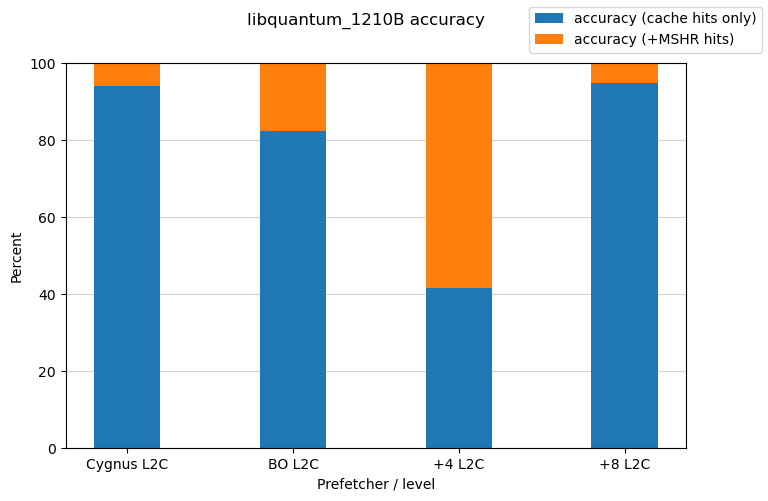

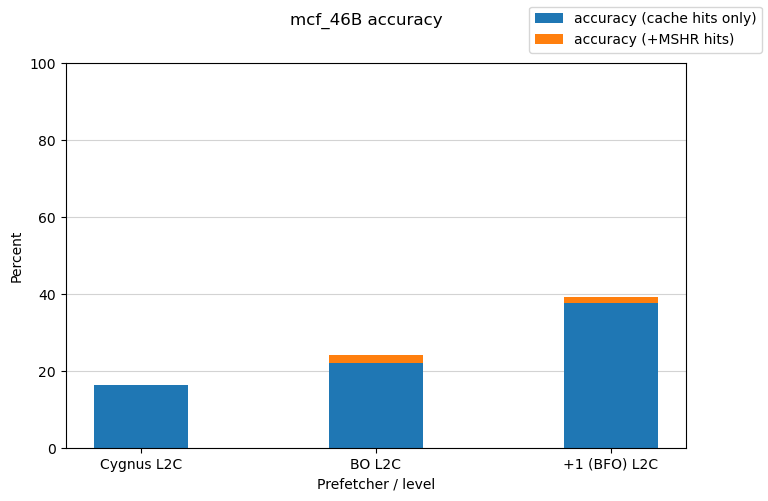

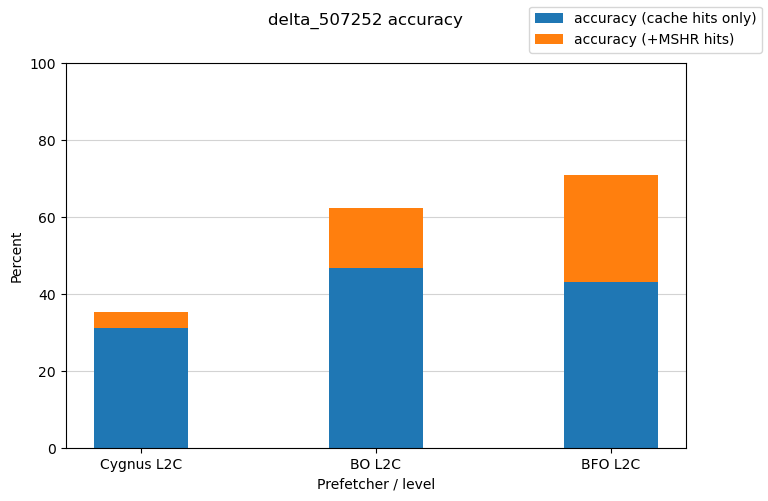

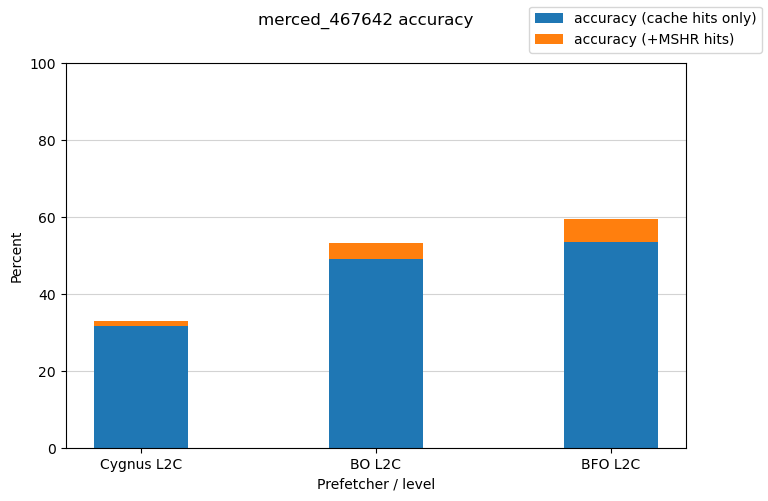

In [14]:
plot_accuracy(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))
plot_accuracy(mcf_prefetchers, 'mcf_46B', figsize=(8, 5))
plot_accuracy(delta_prefetchers, 'delta_507252', figsize=(8, 5))
plot_accuracy(merced_prefetchers, 'merced_467642', figsize=(8, 5))

## Coverage

In [22]:
def plot_coverage(prefetchers, trace, figsize=(8,5)):
    coverage = {}
    coverage_late = {}
    X = []
    
    levels = ['L2C']#, 'LLC']
    for i, (k, v) in enumerate(prefetchers.items()):
        for level in levels:
            b_misses = get_value(v, trace, f'{level}_misses_baseline')
            misses = get_value(v, trace, f'{level}_misses')
            misses_mshr_hit = get_value(v, trace, f'{level}_misses_mshr_hit')

            cov = (b_misses - misses) / b_misses * 100.
            cov_late = (b_misses - (misses - misses_mshr_hit)) / b_misses * 100.

            #coverage[f'{k} {level}'] = cov
            #coverage_late[f'{k} {level}'] = cov_late
            coverage[k] = cov
            coverage_late[k] = cov_late
        X.extend((i + 1) * (len(levels) + 1) + np.arange(len(levels)))
            
    print(coverage.keys())

    #print('Coverage:', coverage)
    #print('Coverage (with MSHR hits):', coverage_late)

    labels = np.array(list(coverage.keys()))
    coverage = np.array(list(coverage.values()))
    coverage_late = np.array(list(coverage_late.values()))

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(X, coverage_late, label='coverage (+MSHR hits)', color='C1')
    ax.bar(X, coverage, label='coverage (cache hits only)', color='C0')

    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('Coverage (%)')
    ax.set_xticks(X)
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(labels)#, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    fig.suptitle(f'{trace} coverage')
    fig.legend()

dict_keys(['Cygnus L2C', 'BO L2C', '+4 L2C', '+8 L2C'])
dict_keys(['Cygnus L2C', 'BO L2C', '+1 (BFO) L2C'])
dict_keys(['Cygnus L2C', 'BO L2C', 'BFO L2C'])
dict_keys(['Cygnus L2C', 'BO L2C', 'BFO L2C'])


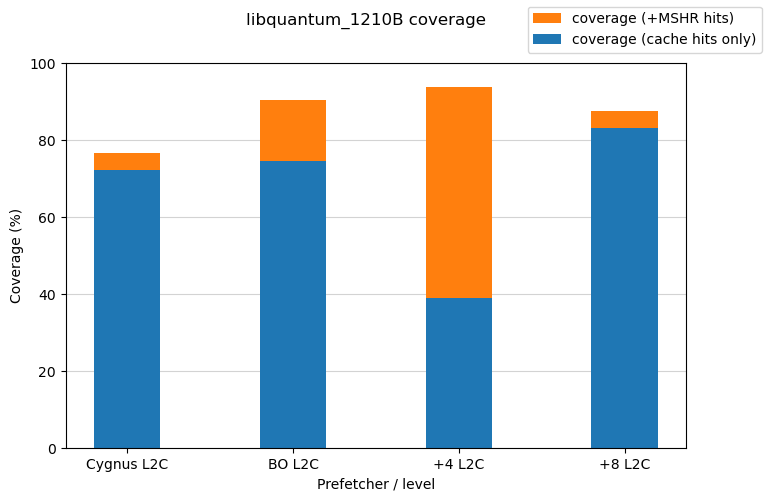

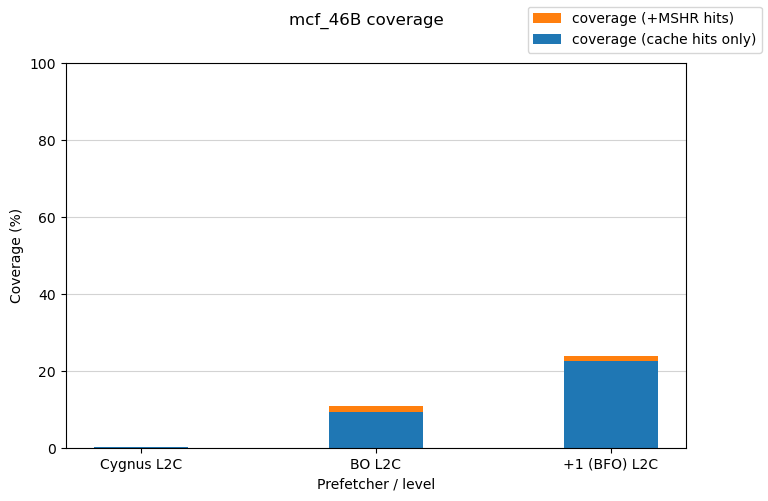

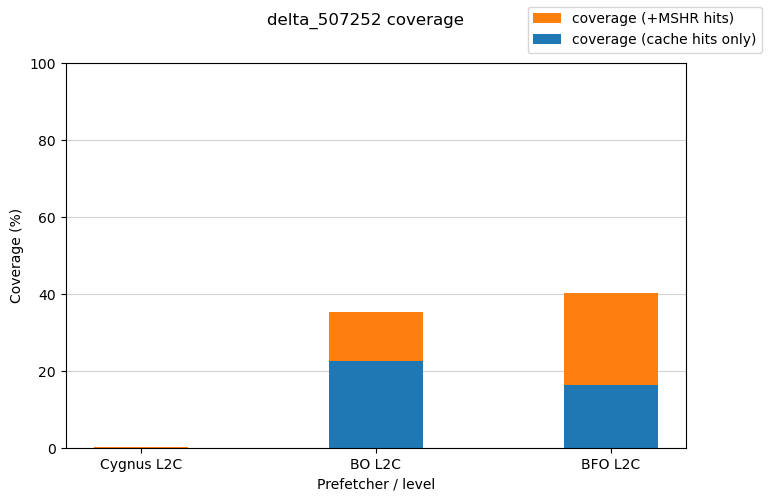

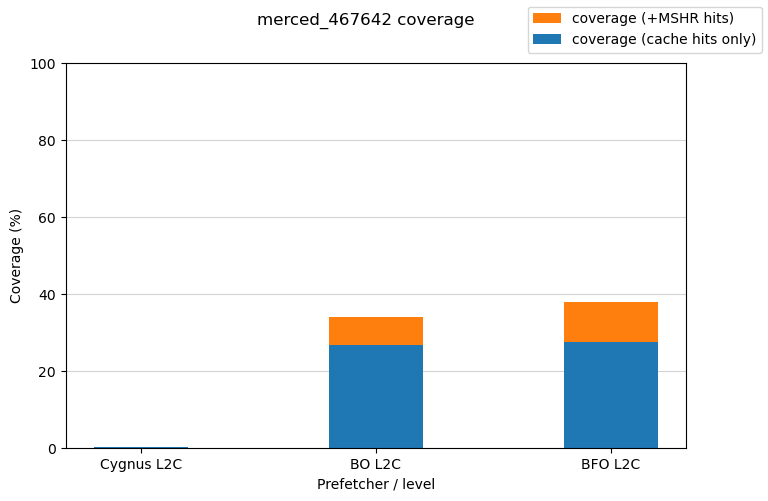

In [16]:
plot_coverage(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))
plot_coverage(mcf_prefetchers, 'mcf_46B', figsize=(8, 5))
plot_coverage(delta_prefetchers, 'delta_507252', figsize=(8, 5))
plot_coverage(merced_prefetchers, 'merced_467642', figsize=(8, 5))

## IPC improvement

In [17]:
def plot_ipc_improvement(prefetchers, trace, figsize=(8,5)):
    ipc_improvement = {}
    ipc_improvement_fixed = {}
    for i, (k, v) in enumerate(prefetchers.items()):
        if 'F' in k:
            ipc_improvement_fixed[k] = get_value(v, trace, 'ipc_improvement')
        else:
            ipc_improvement[k] = get_value(v, trace, 'ipc_improvement')
        
    X = np.arange(len(ipc_improvement))
    X_fixed = np.arange(len(ipc_improvement_fixed)) + len(ipc_improvement) + 1

    #print('Coverage:', coverage)
    #print('Coverage (with MSHR hits):', coverage_late)

    labels = np.array(list(ipc_improvement.keys()))
    labels_fixed = np.array([l.rstrip('F') for l in ipc_improvement_fixed.keys()])
    ipc_improvement = np.array(list(ipc_improvement.values()))
    ipc_improvement_fixed = np.array(list(ipc_improvement_fixed.values()))

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(X, ipc_improvement, label='IPC improvement', color='C0')
    ax.bar(X_fixed, ipc_improvement_fixed, label='IPC improvement (fixed)', color='C1')

    ax.set_xlabel('Prefetcher / level')
    ax.set_ylabel('IPC improvement (%)')
    ax.set_xticks(np.append(X, X_fixed))
    ax.grid(axis='y', color='lightgray')
    ax.set_axisbelow(True)
    ax.set_xticklabels(np.append(labels, labels_fixed))#, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 101, 10))
    fig.suptitle(f'{trace} IPC improvement')
    fig.legend()

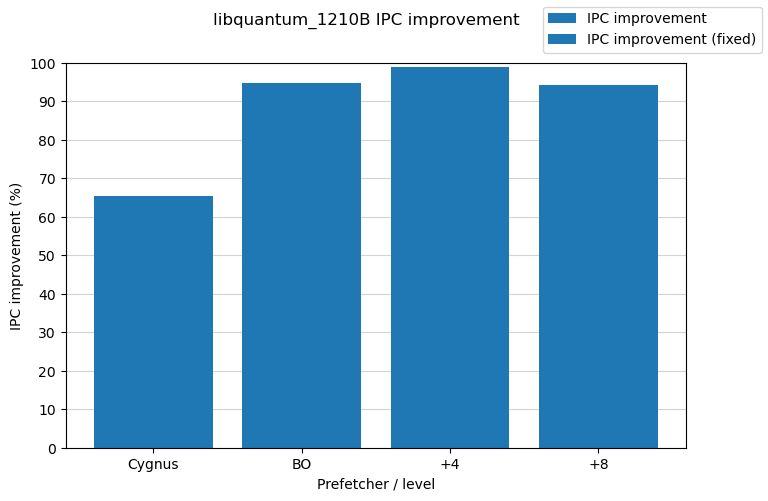

In [18]:
plot_ipc_improvement(libq_prefetchers, 'libquantum_1210B', figsize=(8, 5))

# Fixed-offset analysis

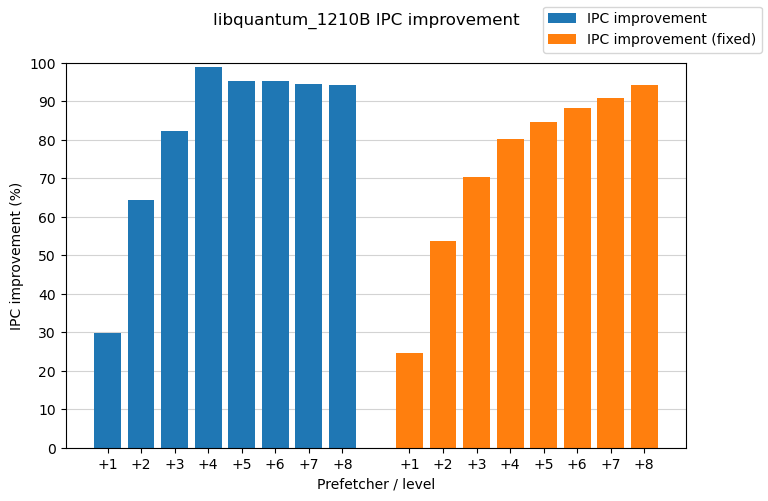

In [19]:
libq_prefetchers_fo = {
    '+1': dfs['degree1_fixed_offset']['1'],
    '+1F': dfs['degree1_fixed_offset_strictpageboundary_8']['1'],
    '+2': dfs['degree1_fixed_offset']['2'],
    '+2F': dfs['degree1_fixed_offset_strictpageboundary_8']['2'],
    '+3': dfs['degree1_fixed_offset']['3'],
    '+3F': dfs['degree1_fixed_offset_strictpageboundary_8']['3'],
    '+4': dfs['degree1_fixed_offset']['4'],
    '+4F': dfs['degree1_fixed_offset_strictpageboundary_8']['4'],
    '+5': dfs['degree1_fixed_offset']['5'],
    '+5F': dfs['degree1_fixed_offset_strictpageboundary_8']['5'],
    '+6': dfs['degree1_fixed_offset']['6'],
    '+6F': dfs['degree1_fixed_offset_strictpageboundary_8']['6'],
    '+7': dfs['degree1_fixed_offset']['7'],
    '+7F': dfs['degree1_fixed_offset_strictpageboundary_8']['7'],
    '+8': dfs['degree1_fixed_offset']['8'],
    '+8F': dfs['degree1_fixed_offset']['8'],
}
plot_ipc_improvement(libq_prefetchers_fo, 'libquantum_1210B', figsize=(8, 5))

dict_keys(['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+1F', '+2F', '+3F', '+4F', '+5F', '+6F', '+7F', '+8F'])


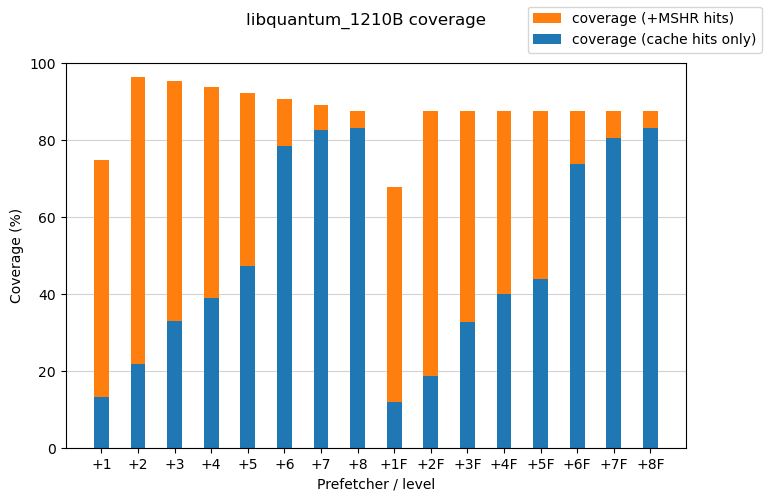

In [25]:
libq_prefetchers_fo = {
    '+1': dfs['degree1_fixed_offset']['1'],
    '+2': dfs['degree1_fixed_offset']['2'],
    '+3': dfs['degree1_fixed_offset']['3'],
    '+4': dfs['degree1_fixed_offset']['4'],
    '+5': dfs['degree1_fixed_offset']['5'], 
    '+6': dfs['degree1_fixed_offset']['6'],
    '+7': dfs['degree1_fixed_offset']['7'],
    '+8': dfs['degree1_fixed_offset']['8'],
    
    '+1F': dfs['degree1_fixed_offset_strictpageboundary_8']['1'],
    '+2F': dfs['degree1_fixed_offset_strictpageboundary_8']['2'],
    '+3F': dfs['degree1_fixed_offset_strictpageboundary_8']['3'],
    '+4F': dfs['degree1_fixed_offset_strictpageboundary_8']['4'],
    '+5F': dfs['degree1_fixed_offset_strictpageboundary_8']['5'],
    '+6F': dfs['degree1_fixed_offset_strictpageboundary_8']['6'],
    '+7F': dfs['degree1_fixed_offset_strictpageboundary_8']['7'],
    '+8F': dfs['degree1_fixed_offset']['8'],
}
plot_coverage(libq_prefetchers_fo, 'libquantum_1210B', figsize=(8, 5))